# Homework 4:
Retrain the 'inception v3' image classifier on the pneumonia dataset using Tensorflow+Keras. Create a jupyter notebook of your script and be sure to show the training process as well as 2 examples of it making predictions on images from the testing dataset. This link will give you an idea of how it can be done. 

In [1]:
#Imports
from PIL import ImageEnhance
from PIL import Image as pil_image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam, SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from zipfile import ZipFile
from os import getcwd
from os.path import isdir
import random


c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
# Uziping the dataset
# dataset taken from: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia#chest_xray.zip
#download chest_xray.zip to the current directory.

print("Current directory: ",  getcwd())

if not isdir("train"):
    with ZipFile("chest_xray.zip") as zipped:
        zipped.extractall()


Current directory:  C:\Workspace\MakeMoneyWithMachineLearning\Week 4\Homework week 4


In [3]:
#Image generators

rescale = 1./255
target_size = (150, 150)
batch_size = 64
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    "chest_xray/train",
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    "chest_xray/val",
    target_size=target_size,
    class_mode=class_mode,
    batch_size=16,
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    "chest_xray/test",
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1000,
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
#Loading InceptionV3 for Transfer Learning
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False
base_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           bat

In [5]:
# Adding custom layers
model = tf.keras.Sequential([
    base_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    #Dense(2, activation='softmax')
    Dense(2, activation='sigmoid')
])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization_94 (Batc (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 22,065,826
Trainable params: 262,786
Non-trainable params: 21,803,040
______________________________________

In [6]:
epochs = 15
total_steps = len(train_generator)
print("Total steps ", total_steps)

steps_per_epoch=len(train_generator)
#steps_per_epoch= int(len(train_generator) / 2)
print("Steps per epoch ", steps_per_epoch)
validation_steps=len(validation_generator)
print(validation_steps)


loss='categorical_crossentropy'
metrics=['accuracy']


model.compile(Adam(), loss=loss, metrics=metrics)

print("Model Done")





Total steps  82
Steps per epoch  82
1
Model Done


In [7]:
print(train_generator.class_indices)
classes = train_generator.class_indices

model_file = "models/" + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

#reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

callbacks =  [ reduce_lr]
#callbacks =  [checkpoint, reduce_lr, early_stopping] #early
#callbacks =  [reduce_lr, early_stopping] 
print("callbacks done")

{'NORMAL': 0, 'PNEUMONIA': 1}
callbacks done


In [8]:
#Training
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=1,
    #use_multiprocessing=True,
    workers=16,
    )

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
82/82 - 20s - loss: 0.3738 - acc: 0.8265 - val_loss: 1.6388 - val_acc: 0.5625
Epoch 2/15
82/82 - 14s - loss: 0.2260 - acc: 0.9099 - val_loss: 0.6071 - val_acc: 0.5625
Epoch 3/15
82/82 - 15s - loss: 0.2140 - acc: 0.9137 - val_loss: 0.9432 - val_acc: 0.6250
Epoch 4/15
82/82 - 15s - loss: 0.2185 - acc: 0.9105 - val_loss: 1.0220 - val_acc: 0.7500
Epoch 5/15

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
82/82 - 16s - loss: 0.2116 - acc: 0.9151 - val_loss: 0.6606 - val_acc: 0.8125
Epoch 6/15
82/82 - 14s - loss: 0.2003 - acc: 0.9160 - val_loss: 0.6588 - val_acc: 0.6875
Epoch 7/15
82/82 - 15s - loss: 0.2083 - acc: 0.9130 - val_loss: 0.7004 - val_acc: 0.6250
Epoch 8/15
82/82 - 15s - loss: 0.1998 - acc: 0.9185 - val_loss: 0.6802 - val_acc: 0.6250
Epoch 9/15

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
82/82 - 15s - loss:

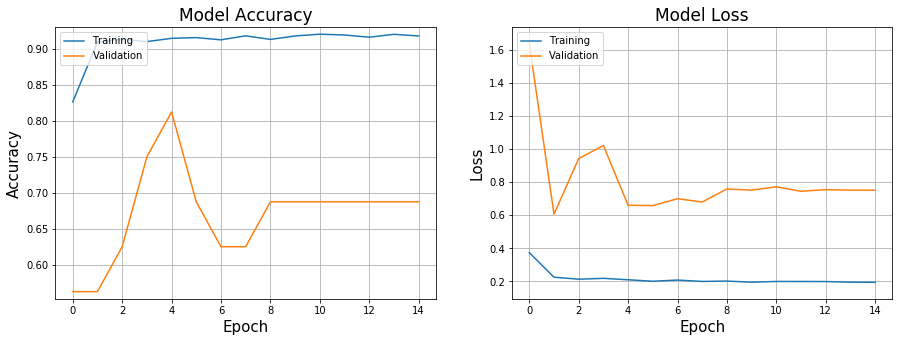

In [9]:
# Showing the training process
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [10]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1, workers=16, )  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

1/1 [==============================] - 11s 11s/step


In [11]:
cls_report = classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"])
print(cls_report)

              precision    recall  f1-score   support

      NORMAL       0.68      0.45      0.54       234
   PNEUMONIA       0.72      0.87      0.79       390

    accuracy                           0.71       624
   macro avg       0.70      0.66      0.67       624
weighted avg       0.71      0.71      0.70       624



Chosen test samples [599, 150, 539, 392, 12, 577, 453, 590, 206, 10, 356, 290, 450, 213, 84, 13, 129, 88, 393, 293, 185, 24, 491, 346]
PNEUMONIA\person88_bacteria_439.jpeg
NORMAL\NORMAL2-IM-0274-0001.jpeg
PNEUMONIA\person57_virus_113.jpeg
PNEUMONIA\person155_bacteria_729.jpeg
NORMAL\IM-0016-0001.jpeg
PNEUMONIA\person82_bacteria_402.jpeg
PNEUMONIA\person1662_virus_2875.jpeg
PNEUMONIA\person85_bacteria_422.jpeg
NORMAL\NORMAL2-IM-0346-0001.jpeg
NORMAL\IM-0013-0001.jpeg
PNEUMONIA\person140_bacteria_667.jpeg
PNEUMONIA\person120_bacteria_570.jpeg
PNEUMONIA\person1660_virus_2869.jpeg
NORMAL\NORMAL2-IM-0353-0001.jpeg
NORMAL\NORMAL2-IM-0058-0001.jpeg
NORMAL\IM-0017-0001.jpeg
NORMAL\NORMAL2-IM-0219-0001.jpeg
NORMAL\NORMAL2-IM-0072-0001.jpeg
PNEUMONIA\person155_bacteria_730.jpeg
PNEUMONIA\person120_bacteria_573.jpeg
NORMAL\NORMAL2-IM-0321-0001.jpeg
NORMAL\IM-0033-0001-0001.jpeg
PNEUMONIA\person1_virus_7.jpeg
PNEUMONIA\person137_bacteria_655.jpeg


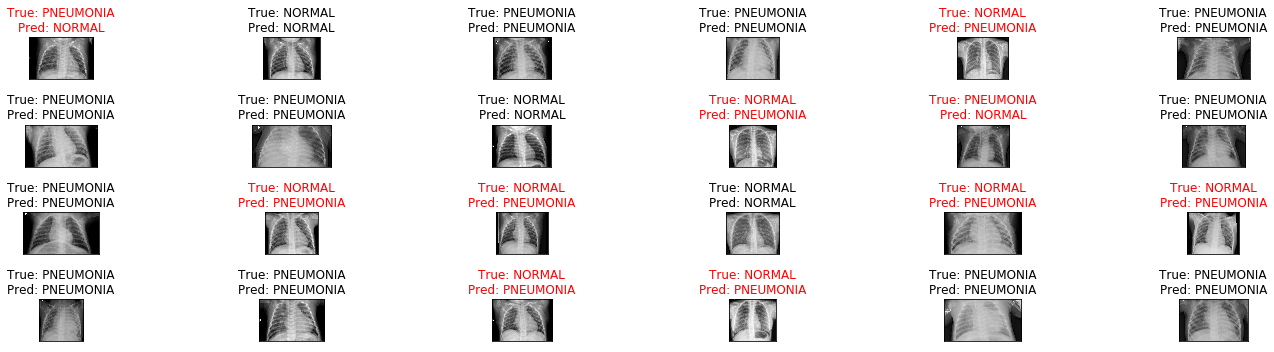

Chosen test samples [539, 205, 227, 620, 487, 199, 476, 127, 616, 555, 458, 393, 388, 99, 40, 43, 190, 518, 52, 310, 390, 22, 12, 495]
PNEUMONIA\person57_virus_113.jpeg
NORMAL\NORMAL2-IM-0345-0001.jpeg
NORMAL\NORMAL2-IM-0374-0001-0001.jpeg
PNEUMONIA\person96_bacteria_466.jpeg
PNEUMONIA\person1_virus_11.jpeg
NORMAL\NORMAL2-IM-0337-0001.jpeg
PNEUMONIA\person172_bacteria_828.jpeg
NORMAL\NORMAL2-IM-0213-0001.jpeg
PNEUMONIA\person94_bacteria_458.jpeg
PNEUMONIA\person75_virus_136.jpeg
PNEUMONIA\person1668_virus_2882.jpeg
PNEUMONIA\person155_bacteria_730.jpeg
PNEUMONIA\person152_bacteria_724.jpeg
NORMAL\NORMAL2-IM-0107-0001.jpeg
NORMAL\IM-0065-0001.jpeg
NORMAL\IM-0070-0001.jpeg
NORMAL\NORMAL2-IM-0327-0001.jpeg
PNEUMONIA\person3_virus_16.jpeg
NORMAL\IM-0085-0001.jpeg
PNEUMONIA\person125_bacteria_594.jpeg
PNEUMONIA\person153_bacteria_726.jpeg
NORMAL\IM-0030-0001.jpeg
NORMAL\IM-0016-0001.jpeg
PNEUMONIA\person21_virus_52.jpeg


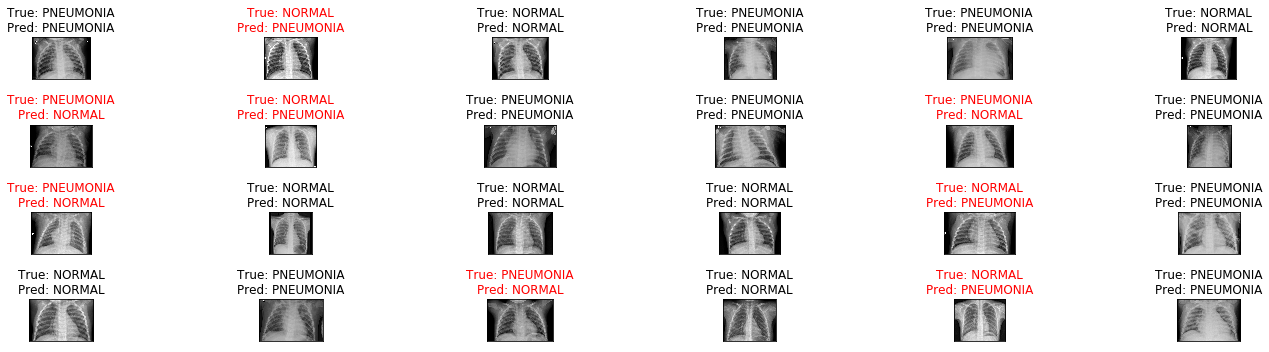

In [12]:
# Show examples of predictions
class_map = {v: k for k, v in test_generator.class_indices.items()}
ncols = 6
nrows = 4

count = ncols*nrows


for i in range(2):
    plt.figure(figsize=(20, 5))
    picks = random.sample(range(len(test_generator.filenames)), count)
    print("Chosen test samples", picks)

    for i, pick in enumerate(picks):
        plt.subplot(nrows, ncols, i+1)
        print(test_generator.filenames[pick])
        img = cv2.imread("chest_xray/test/"+ test_generator.filenames[pick], 1)

        #print(img)

        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

        original = class_map[y_true[pick]]
        predicted = class_map[y_pred[pick]]


        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))

        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')

    plt.tight_layout()
    plt.show()
